# Angle-based Joint and Individual Variation (AJIVE) Explained

Adopted from the code at https://github.com/idc9/py_jive and their tutorial written by:

Author: Iain Carmichael

License: MIT License

--

AJIVE is a useful algorithm that decomposes multiple views of data into three main categories:
- Joint Variation
- Individual Variation
- Noise

This notebook will prove out the implementation of AJIVE and show some examples of the algorithm's usefulness

In [28]:
import numpy as np
from mvlearn.decomposition import AJIVE, data_block_heatmaps, ajive_full_estimate_heatmaps
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Creation

Here we create data in the same way detailed in the initial JIVE paper:
<blockquote>
    [1] Lock, Eric F., et al. “Joint and Individual Variation Explained (JIVE) for Integrated Analysis of Multiple Data Types.”        The Annals of Applied Statistics, vol. 7, no. 1, 2013, pp. 523–542., doi:10.1214/12-aoas597.
</blockquote>

The two views are created with shared joint variation, unique individual variation, and independent noise. A representation of what the implementation of this algorithm does can be seen in the cell below.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0047259X1730204X-gr1.jpg">


In [2]:
np.random.seed(12)

# First View
V1_joint = np.bmat([[-1 * np.ones((50, 2000))],
                       [np.ones((50, 2000))]])

V1_joint = np.bmat([np.zeros((100, 8000)), V1_joint])

V1_indiv_t = np.bmat([[np.ones((20, 5000))],
                        [-1 * np.ones((20, 5000))],
                        [np.zeros((20, 5000))],
                        [np.ones((20, 5000))],
                        [-1 * np.ones((20, 5000))]])

V1_indiv_b = np.bmat([[np.ones((25, 5000))],
                        [-1 * np.ones((50, 5000))],
                        [np.ones((25, 5000))]])

V1_indiv_tot = np.bmat([V1_indiv_t, V1_indiv_t])

V1_noise = np.random.normal(loc=0, scale=1, size=(100, 10000))


# Second View
V2_joint = np.bmat([[np.ones((50, 50))],
                      [-1*np.ones((50, 50))]])

V2_joint = 5000 * np.bmat([V2_joint, np.zeros((100, 50))])

V2_indiv = 5000 * np.bmat([[-1 * np.ones((25, 100))],
                              [np.ones((25, 100))],
                              [-1 * np.ones((25, 100))],
                              [np.ones((25, 100))]])

V2_noise = 5000 * np.random.normal(loc=0, scale=1, size=(100, 100))

# View Construction

V1 = V1_indiv_tot + V1_joint + V1_noise

V2 = V2_indiv + V2_joint + V2_noise

Views_1 = [V1, V1]
Views_2 = [V1, V2]

## Scree Plots

Scree plots allow us to observe variation and determine an appropriate initial signal rank for each view.

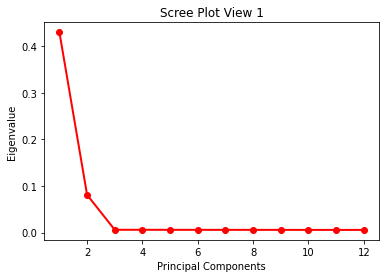

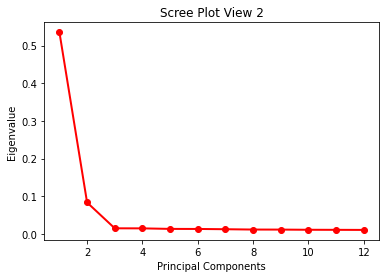

<Figure size 432x288 with 0 Axes>

In [3]:
def scree_plot(n,V,name):
    U, S, V = np.linalg.svd(V)
    eigvals = S**2 / np.sum(S**2)
    eigval_terms = np.arange(n) + 1
    plt.plot(eigval_terms, eigvals[0:n], 'ro-', linewidth=2)
    plt.title('Scree Plot '+ name)
    plt.xlabel('Principal Components')
    plt.ylabel('Eigenvalue')
    plt.figure()

scree_plot(12,V1,'View 1')
scree_plot(12,V2,'View 2')

Based on the scree plots, we fit AJIVE with both initial signal ranks set to 2.

In [82]:
ajive1 = AJIVE(init_signal_ranks=[2,2])
Js_1 = ajive1.fit_transform(Xs=[V1,V1])

ajive2 = AJIVE(init_signal_ranks=[2,2])
Js_2 = ajive2.fit_transform(Xs=[V1,V2])

## Heatmap Visualizations

Here we are using heatmaps to visualize the decomposition of our views. As we can see when we use two of the same views there is no Individualized Variation displayed. When we create two different views, the algorithm finds different decompositions where common and individual structural artifacts can be seen in their corresponding heatmaps.

In [83]:
def plot_blocks(blocks, names):
    n_views = len(blocks[0])
    n_blocks = len(blocks)
    for i in range(n_views):
        for j in range(n_blocks):
            plt.subplot(n_blocks, n_views, j*n_views+i+1)
            sns.heatmap(blocks[j][i], xticklabels=False, yticklabels=False, cmap="RdBu")
            plt.title(f"View {i}: {names[j]}")

### Same Views

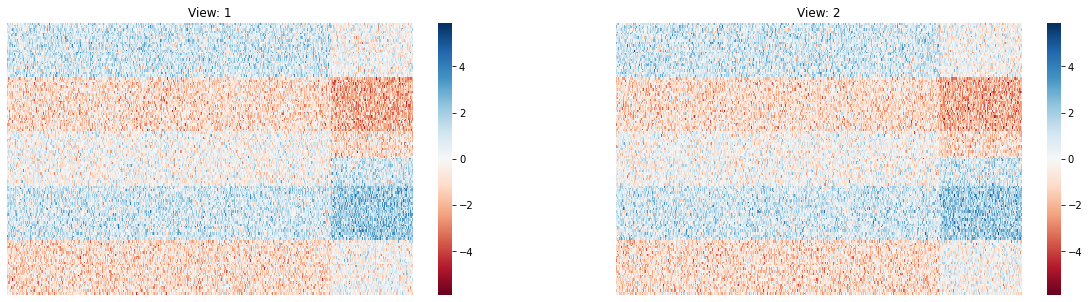

In [84]:
plt.figure(figsize=[20, 5])
data_block_heatmaps(Views_1)

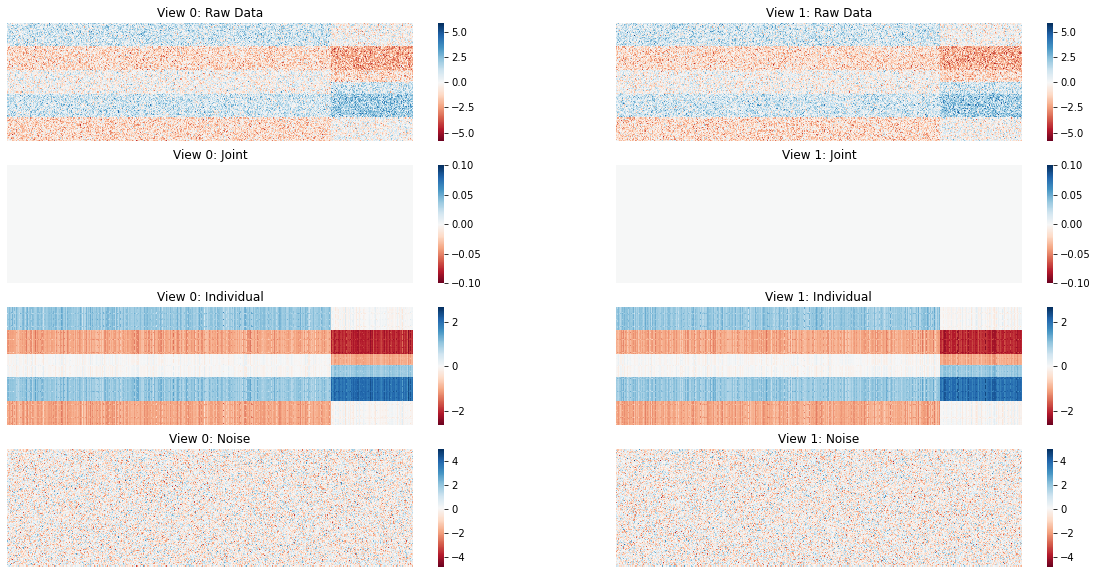

In [85]:
plt.figure(figsize=[20, 10])
plt.title('Same Views')
residuals = [v1 - X for v1,X in zip(Views_1, ajive1.inverse_transform(Js_1))]
indiv_1 = ajive1.indiv_mats_
plot_blocks([Views_1, Js_1, indiv_1, residuals], ["Raw Data", "Joint", "Individual", "Noise"])

### Different Views

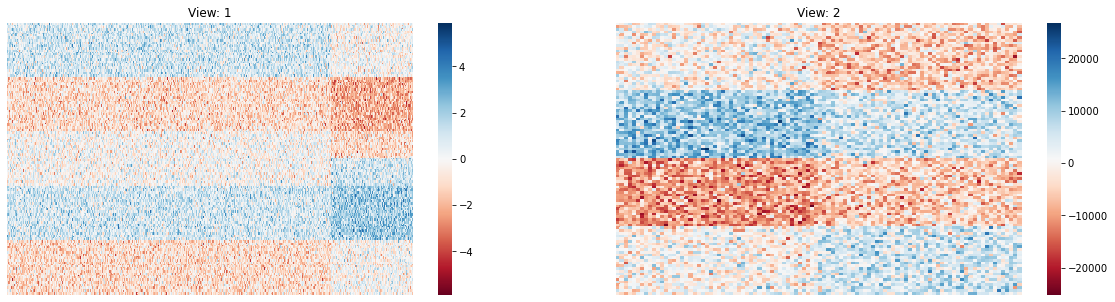

In [86]:
plt.figure(figsize=[20, 5])
data_block_heatmaps(Views_2)

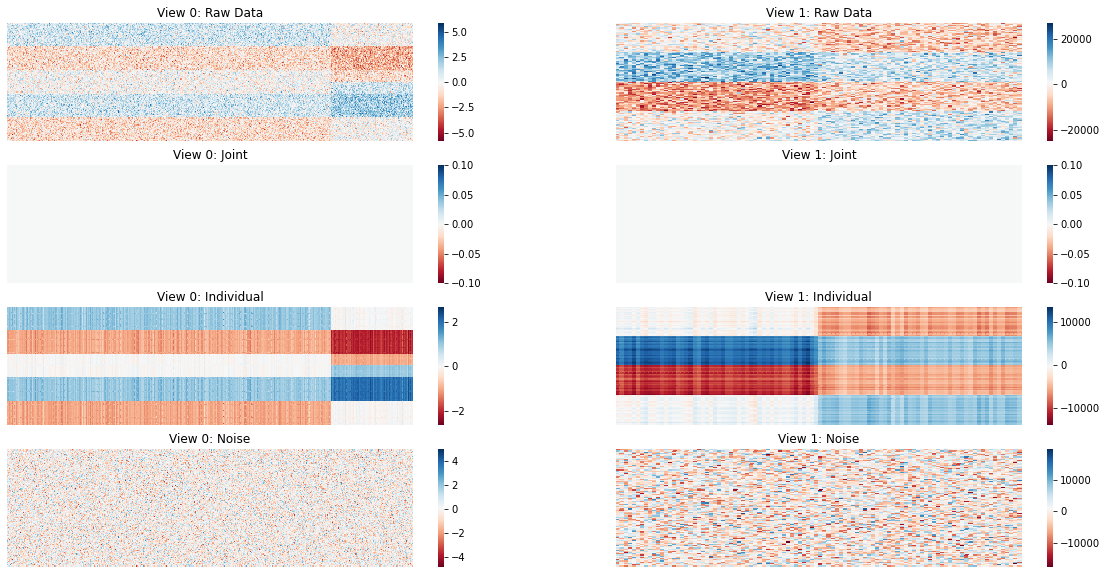

In [87]:
plt.figure(figsize=[20, 10])
plt.title('Different Views')
indiv_mats = ajive2.indiv_mats_
Xs_inv = ajive2.inverse_transform(Js_2)
residuals = [v - X for v,X in zip(Views_2, Xs_inv)]
plot_blocks([Views_2, Js_2, indiv_mats, residuals], ["Raw Data", "Joint", "Individual", "Noise"])

In [96]:
ajive2.wedin_sv_samples_

array([1.87667546, 1.87933874, 1.8668573 , 1.88582298, 1.88860724,
       1.87580825, 1.89276983, 1.88492474, 1.88812864, 1.87707914,
       1.8816946 , 1.89053643, 1.88489631, 1.87849414, 1.87000665,
       1.89842638, 1.86520128, 1.88390296, 1.88705941, 1.88001592,
       1.87985196, 1.87678673, 1.88700763, 1.86911062, 1.88427243,
       1.88279142, 1.88187777, 1.88269035, 1.87817636, 1.87324183,
       1.88964574, 1.87734486, 1.87438789, 1.8796138 , 1.88459423,
       1.88716715, 1.88782929, 1.88387841, 1.88823299, 1.88773297,
       1.87622035, 1.88804881, 1.89559368, 1.88185957, 1.88398018,
       1.88075549, 1.86256801, 1.88049796, 1.87331939, 1.88818013,
       1.87791867, 1.87713303, 1.88583441, 1.88490965, 1.88116149,
       1.87521158, 1.8817823 , 1.88568544, 1.88216159, 1.88331027,
       1.88265128, 1.87794867, 1.89221549, 1.88209222, 1.86886645,
       1.88228397, 1.88351046, 1.8802033 , 1.86931876, 1.88605746,
       1.88948279, 1.86758092, 1.88496105, 1.88300698, 1.88841

In [102]:
np.array([sum([w[i]**2 for w in ajive2.wedin_samples_])
    for i in range(ajive2.n_wedin_samples)]
)

array([0.12332454, 0.12066126, 0.1331427 , 0.11417702, 0.11139276,
       0.12419175, 0.10723017, 0.11507526, 0.11187136, 0.12292086,
       0.1183054 , 0.10946357, 0.11510369, 0.12150586, 0.12999335,
       0.10157362, 0.13479872, 0.11609704, 0.11294059, 0.11998408,
       0.12014804, 0.12321327, 0.11299237, 0.13088938, 0.11572757,
       0.11720858, 0.11812223, 0.11730965, 0.12182364, 0.12675817,
       0.11035426, 0.12265514, 0.12561211, 0.1203862 , 0.11540577,
       0.11283285, 0.11217071, 0.11612159, 0.11176701, 0.11226703,
       0.12377965, 0.11195119, 0.10440632, 0.11814043, 0.11601982,
       0.11924451, 0.13743199, 0.11950204, 0.12668061, 0.11181987,
       0.12208133, 0.12286697, 0.11416559, 0.11509035, 0.11883851,
       0.12478842, 0.1182177 , 0.11431456, 0.11783841, 0.11668973,
       0.11734872, 0.12205133, 0.10778451, 0.11790778, 0.13113355,
       0.11771603, 0.11648954, 0.1197967 , 0.13068124, 0.11394254,
       0.11051721, 0.13241908, 0.11503895, 0.11699302, 0.11158

In [108]:
ajive2.wedin_samples_[0]

[0.2520402456256643,
 0.2522456155562654,
 0.24846605444969166,
 0.25091114337226833,
 0.2500357320076199,
 0.2500454915783322,
 0.24759514098012103,
 0.25016532803935293,
 0.2500629710095358,
 0.2500500230211257,
 0.24886232561519497,
 0.24836312555198803,
 0.24918197951524756,
 0.2482597377735909,
 0.2487427618031978,
 0.24972861923125553,
 0.24735692399090398,
 0.25347237695024244,
 0.25426210940039357,
 0.2503934708243901,
 0.2500586765404515,
 0.2495673044560874,
 0.24953692416128193,
 0.24950231222883948,
 0.24771258690870923,
 0.2500641523311983,
 0.25084151133262284,
 0.2487964119701678,
 0.2490000738493618,
 0.25094736817656055,
 0.24694865799996343,
 0.24913395637364508,
 0.25088130049996904,
 0.25010802950886013,
 0.2500730365957549,
 0.25061023386521913,
 0.248697238409561,
 0.24980166996961795,
 0.2470761194951633,
 0.24798560655673724,
 0.2491666054246821,
 0.24641776412104605,
 0.2507430146394605,
 0.24885197049788213,
 0.24833173283228277,
 0.25272591064577055,
 0.24903